#Step 1 : Problem Statement

## 1. Predict future air pollution levels (e.g., PM2.5 concentration) using historical time series data with an LSTM neural network.

###Why is this important?
 - Air pollution, especially fine particulate matter such as PM2.5, is a major public health concern globally. Exposure to high levels of PM2.5 is linked to respiratory diseases, cardiovascular problems, and premature mortality (World Health Organization, 2021). Accurate forecasting of air pollution levels enables authorities and communities to implement timely interventions, reduce exposure, and improve air quality management (Chen et al., 2019).

###What is the problem?
 - Predicting future air pollution concentrations involves modeling complex temporal dynamics influenced by various factors like meteorological conditions, traffic emissions, and industrial activity. Traditional statistical models often struggle to capture these nonlinear dependencies, necessitating more advanced methods (Shen et al., 2020).

###How will this be addressed?
  - Long Short-Term Memory (LSTM) networks, a type of recurrent neural network designed to handle sequential data and long-term dependencies, have demonstrated strong performance in time series forecasting tasks, including air pollution prediction (Zhang et al., 2018). This project will develop an LSTM-based forecasting model trained on historical air pollution and meteorological data to predict future PM2.5 levels, providing actionable insights for pollution control.

In [ ]:
#@title Importing Libraries

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


# Step 2 : Data Collection

Kaggel Link for the dataset : https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate/data

In [ ]:
df_original = pd.read_csv("https://raw.githubusercontent.com/dipdhru/data_set/refs/heads/main/Multivariate_pollution.csv", parse_dates=['date'], index_col='date')


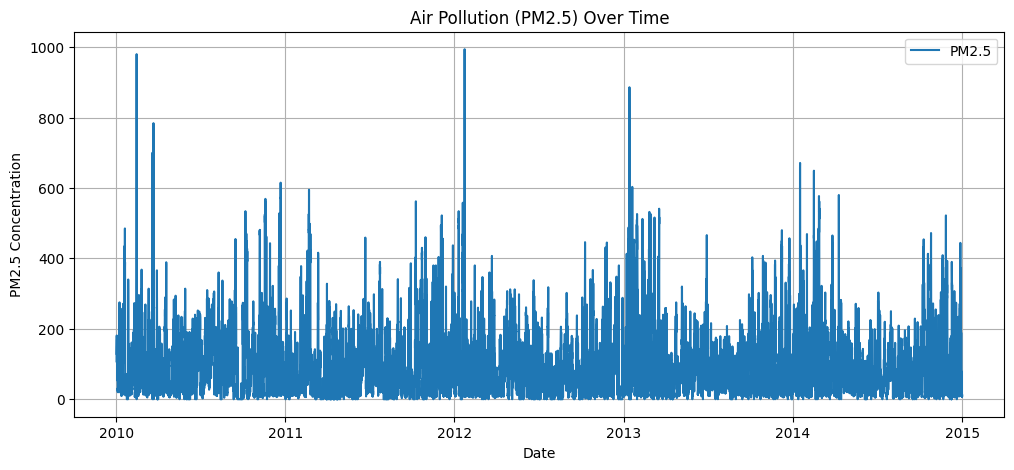

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df_original.index, df_original['pollution'], label='PM2.5')
plt.title('Air Pollution (PM2.5) Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pd.set_option('display.max_columns', None)
df_original.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


#Step 3 : Data Exploration

In [ ]:
split_ratio = 0.8  # Use 80% of data for training, 20% for validation
split_index = int(len(df_original) * split_ratio)

df_train = df_original.iloc[:split_index]
df_valid = df_original.iloc[split_index:]


#Size & Size of Train & Test
print(f'Train Dataset Shape : {df_train.shape} & Train Dataset Shape : {df_train.shape}','\n')
print(f'Test Dataset Shape : {df_valid.shape} & Test Dataset Shape : {df_valid.shape}','\n','- '*75)

#Look on columns datatypes
print(df_train.dtypes,'\n','- '*75)

#Preview last 5 rows
pd.set_option('display.max_columns', None)
df_train.tail()

Train Dataset Shape : (35040, 8) & Train Dataset Shape : (35040, 8) 

Test Dataset Shape : (8760, 8) & Test Dataset Shape : (8760, 8) 
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
pollution    float64
dew            int64
temp         float64
press        float64
wnd_dir       object
wnd_spd      float64
snow           int64
rain           int64
dtype: object 
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2013-12-31 19:00:00,22.0,-19,7.0,1013.0,NW,114.87,0,0
2013-12-31 20:00:00,18.0,-21,7.0,1014.0,NW,119.79,0,0
2013-12-31 21:00:00,23.0,-21,7.0,1014.0,NW,125.60,0,0
2013-12-31 22:00:00,20.0,-21,6.0,1014.0,NW,130.52,0,0
2013-12-31 23:00:00,23.0,-20,7.0,1014.0,NW,137.67,0,0


In [ ]:
#Total Duplicates
print(f'Total Duplicates in Train Dataset : {df_train.reset_index().duplicated().sum()}')

#Total Null
print(f'Total Nulls in Train Dataset : {df_train.isna().sum().sum()}','\n','- '*75)

#Statistical Analysis
df_train.describe(include='all').T

Total Duplicates in Train Dataset : 0
Total Nulls in Train Dataset : 0 
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
pollution,35040.0,NaN,NaN,NaN,93.359389,91.908697,0.0,24.0,67.0,133.0,994.0
dew,35040.0,NaN,NaN,NaN,1.772603,14.494913,-33.0,-11.0,2.0,15.0,28.0
temp,35040.0,NaN,NaN,NaN,12.15391,12.307034,-19.0,1.0,13.0,23.0,41.0
press,35040.0,NaN,NaN,NaN,1016.399743,10.386205,991.0,1008.0,1016.0,1025.0,1046.0
wnd_dir,35040,4,SE,12068,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wnd_spd,35040.0,NaN,NaN,NaN,24.963223,51.315742,0.45,1.79,5.81,23.25,585.6
snow,35040.0,NaN,NaN,NaN,0.057477,0.773838,0.0,0.0,0.0,0.0,27.0
rain,35040.0,NaN,NaN,NaN,0.209874,1.489928,0.0,0.0,0.0,0.0,36.0


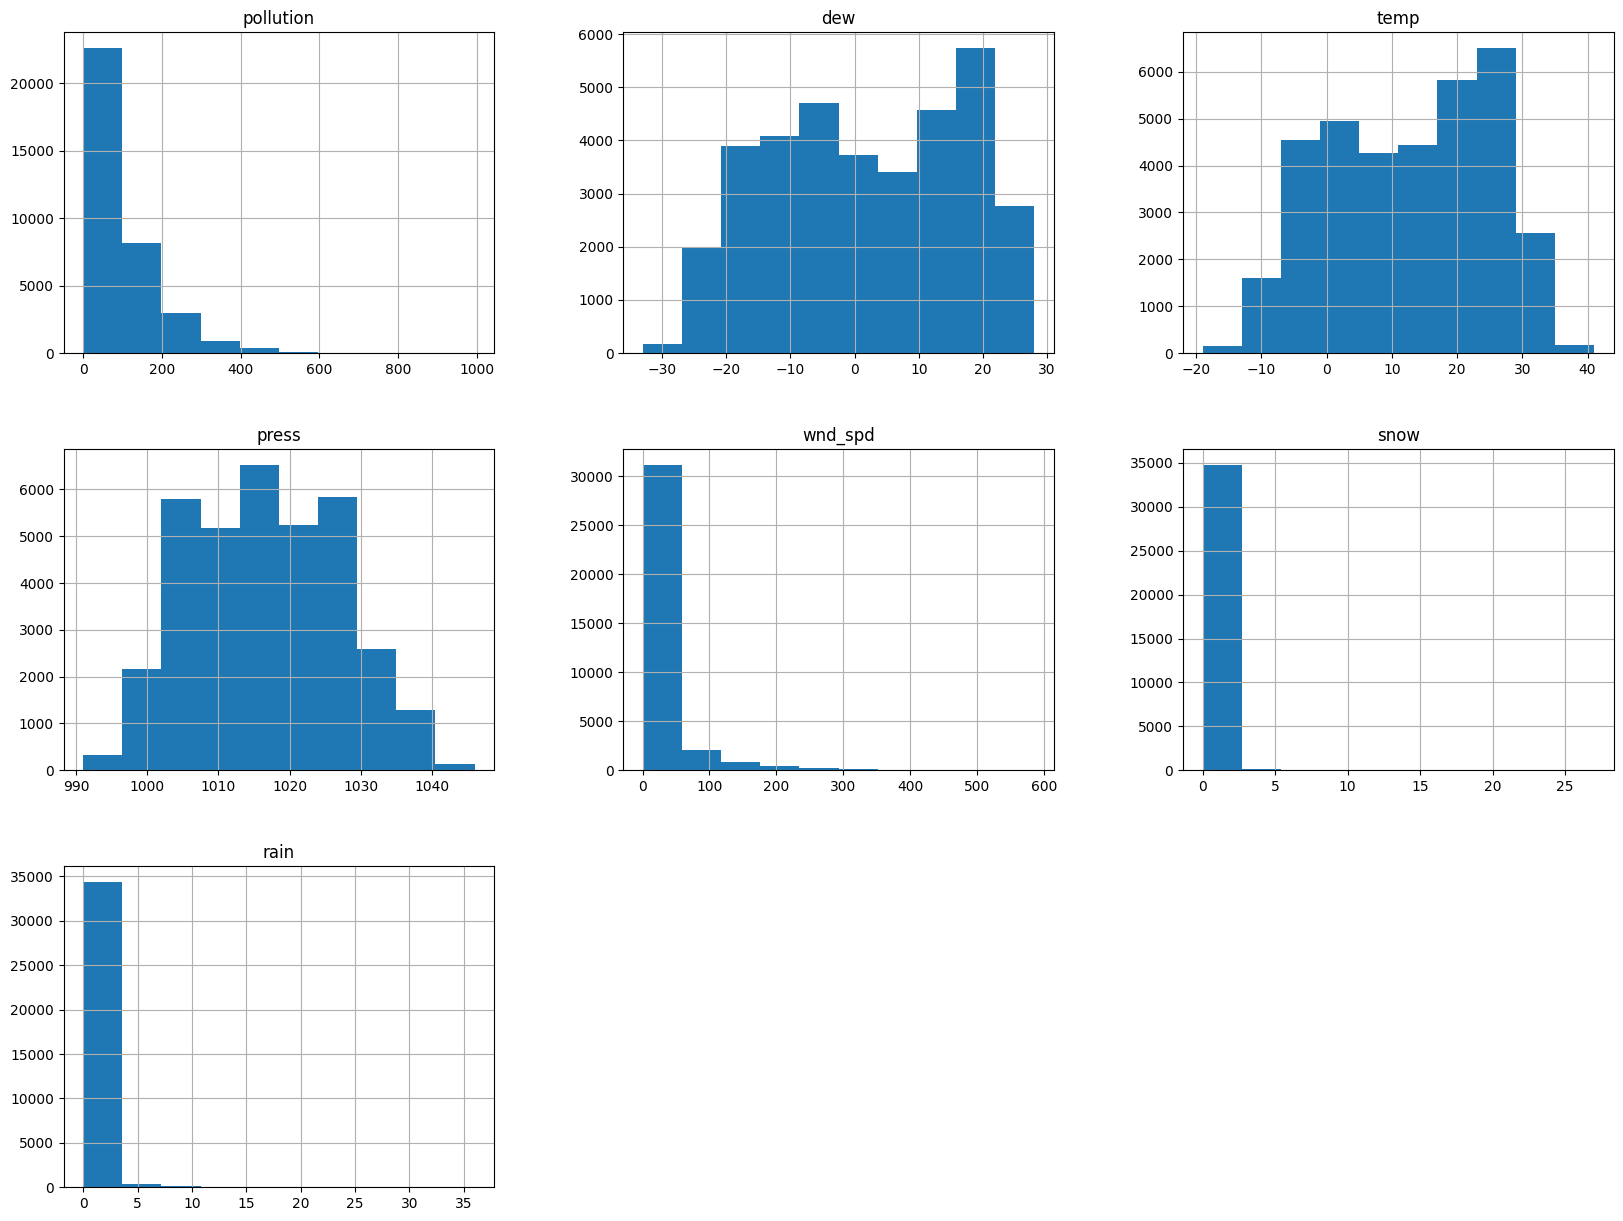

In [ ]:
df_train.hist(figsize=(20,15))
plt.show()

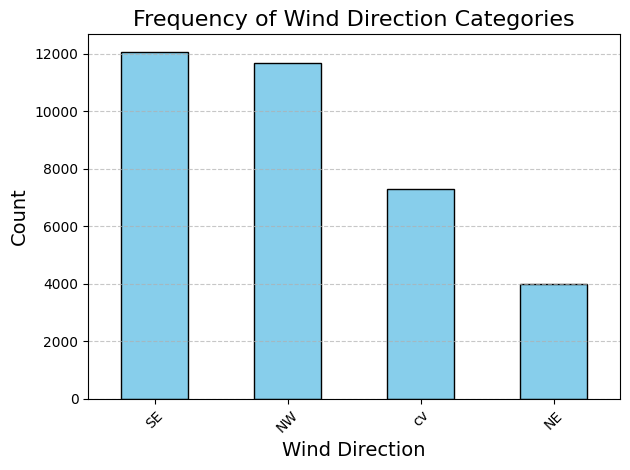

In [ ]:
df_train['wnd_dir'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Frequency of Wind Direction Categories', fontsize=16)
plt.xlabel('Wind Direction', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

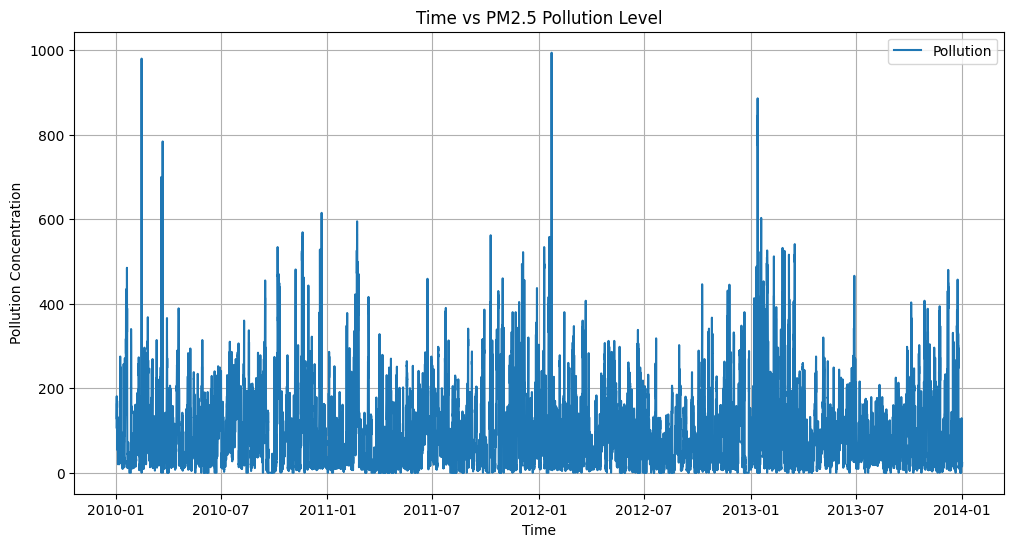

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df_train.index, df_train['pollution'], label='Pollution')

plt.title('Time vs PM2.5 Pollution Level')
plt.xlabel('Time')
plt.ylabel('Pollution Concentration')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Function to detect anomalies and inconsistent data types
def analyze_anomalies(df):
    summary = []
    inconsistent_dtype_count = 0
    total_anomaly_count = 0

    for col in df.columns:
        dtype = df[col].dtype

        if dtype in ['int64', 'float64']:
            # Calculate Q1 (25th percentile) and Q3 (75th percentile) for IQR
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            anomaly_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        else:
            anomaly_count = 0

        total_anomaly_count += anomaly_count


        if df[col].apply(type).nunique() > 1:
            mixed_data = 1
            inconsistent_dtype_count += 1
        else:
            mixed_data = 0
        summary.append([col, dtype, anomaly_count, mixed_data])
    summary_df = pd.DataFrame(summary, columns=["Column Name", "Data Type", "Anomaly Count (IQR)", "Is Datatype Consistet"])
    summary_df.loc["Total"] = ["Total", "", total_anomaly_count, inconsistent_dtype_count]

    return summary_df

analyze_anomalies(df_train)

,Column Name,Data Type,Anomaly Count (IQR),Is Datatype Consistet
0,pollution,float64,1368,0
1,dew,int64,0,0
2,temp,float64,0,0
3,press,float64,0,0
4,wnd_dir,object,0,0
5,wnd_spd,float64,4084,0
6,snow,int64,331,0
7,rain,int64,1516,0
Total,Total,,7299,0


#Step 4 : Data Preprocessing

As we dont have missing values and duplicate values so we can avoid those pre-processing steps which include filling null values and dupicate removal. Therefore we will directly work on anamolies removal.

In [ ]:
df_train_preprocessed = df_train.copy()
df_valid_preprocessed = df_valid.copy()

In [ ]:
def cap_outliers(df):
    """Caps outliers using the IQR method instead of removing them."""
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

    # Calculate Q1, Q3, and IQR for each numerical feature
    Q1 = df[numerical_features].quantile(0.25)
    Q3 = df[numerical_features].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap values outside the range
    df[numerical_features] = df[numerical_features].clip(lower=lower_bound, upper=upper_bound, axis=1)

    return df


df_train_preprocessed = cap_outliers(df_train_preprocessed)
df_valid_preprocessed = cap_outliers(df_valid_preprocessed)

analyze_anomalies(df_train_preprocessed)

,Column Name,Data Type,Anomaly Count (IQR),Is Datatype Consistet
0,pollution,float64,0,0
1,dew,int64,0,0
2,temp,float64,0,0
3,press,float64,0,0
4,wnd_dir,object,0,0
5,wnd_spd,float64,0,0
6,snow,int64,0,0
7,rain,int64,0,0
Total,Total,,0,0


#Step 5 : Feature Extraction

In [ ]:
df_train_fe = df_train_preprocessed.copy()
df_valid_fe = df_valid_preprocessed.copy()

Adding Basic Statistical Feature called mean(per time window or globally)

In [ ]:
df_train_fe['pollution_rolling_mean_3h'] = df_train_fe['pollution'].rolling(window=3).mean()
df_train_fe['pollution_diff_1h'] = df_train_fe['pollution'].diff()

df_valid_fe['pollution_rolling_mean_3h'] = df_valid_fe['pollution'].rolling(window=3).mean()
df_valid_fe['pollution_diff_1h'] = df_valid_fe['pollution'].diff()

Lag Features (Shifting)

In [ ]:
for lag in range(1, 4):
    df_train_fe[f'pollution_lag_{lag}'] = df_train_fe['pollution'].shift(lag)
    df_valid_fe[f'pollution_lag_{lag}'] = df_valid_fe['pollution'].shift(lag)

Extracting cyclical time features

In [ ]:
df_train_fe['hour'] = df_train_fe.index.hour
df_train_fe['hour_sin'] = np.sin(2 * np.pi * df_train_fe['hour'] / 24)
df_train_fe['hour_cos'] = np.cos(2 * np.pi * df_train_fe['hour'] / 24)

df_valid_fe['hour'] = df_valid_fe.index.hour
df_valid_fe['hour_sin'] = np.sin(2 * np.pi * df_valid_fe['hour'] / 24)
df_valid_fe['hour_cos'] = np.cos(2 * np.pi * df_valid_fe['hour'] / 24)

In [ ]:
df_train_fe.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution_rolling_mean_3h,pollution_diff_1h,pollution_lag_1,pollution_lag_2,pollution_lag_3,hour,hour_sin,hour_cos
date,,,,,,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0,NaN,NaN,NaN,NaN,NaN,0,0.000000,1.000000
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0,NaN,19.0,129.0,NaN,NaN,1,0.258819,0.965926
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0,145.333333,11.0,148.0,129.0,NaN,2,0.500000,0.866025
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,0,0,162.666667,22.0,159.0,148.0,129.0,3,0.707107,0.707107
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,0,0,159.333333,-43.0,181.0,159.0,148.0,4,0.866025,0.500000


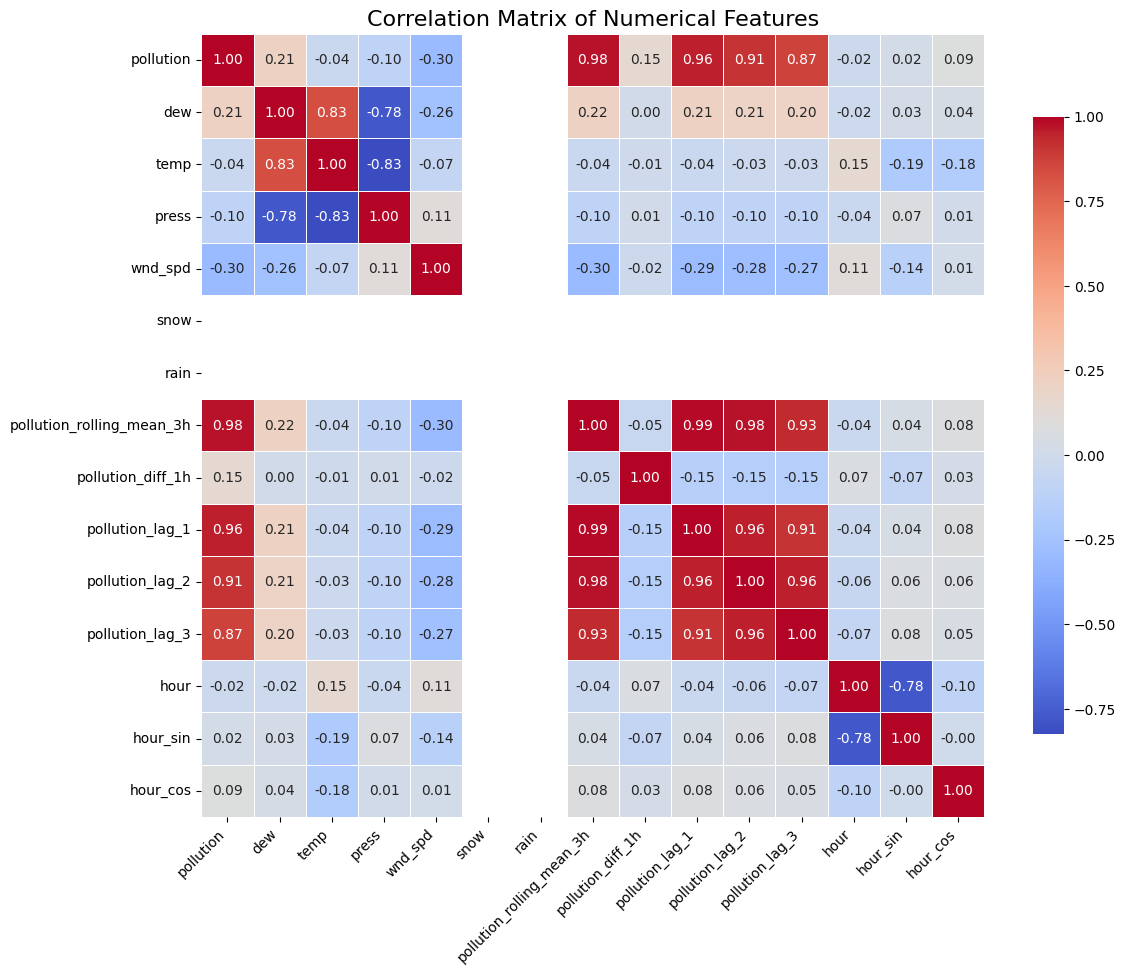

In [ ]:
df_train_fe.dropna(inplace=True)
df_valid_fe.dropna(inplace=True)

numerical_cols = df_train_fe.select_dtypes(include=np.number).columns

correlation_matrix = df_train_fe[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={"shrink": .75}, linewidths=0.5)

plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


- Pollution and its lagged features:

  1. The current pollution level is very strongly positively correlated with its lagged values (pollution_lag_1, pollution_lag_2, pollution_lag_3) and rolling mean (pollution_rolling_mean_3h), with correlations mostly above 0.87.

  2. This indicates pollution levels are highly dependent on recent past values, showing strong temporal persistence.

- Pollution and pollution difference:

  1. The pollution_diff_1h feature has a weak positive correlation (~0.15) with pollution, reflecting small incremental changes from hour to hour.

- Weather-related variables:

  1. dew and temp are strongly correlated with each other (0.83) but negatively correlated with press (-0.78 to -0.83).

  2. Pollution has a weak to moderate positive correlation with dew (0.21) but slight negative or negligible correlation with temp and press.

  3. wnd_spd (wind speed) is moderately negatively correlated with pollution (~-0.30), suggesting higher wind speeds might help disperse pollutants.

- Time features:

  1. Hourly cyclic features (hour_sin, hour_cos) and hour itself show very low correlation with pollution, indicating that time-of-day patterns alone are not strong predictors but could still be useful in models.

- Other features like snow and rain:

  1. Appear to have very low or no significant correlation with pollution in this matrix (mostly blank or near zero), possibly due to sparse or zero values.

In [ ]:
categorical_cols = df_train_fe.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df_train_fe.select_dtypes(include=['number']).columns.tolist()

df_train_fe_encoded = pd.get_dummies(df_train_fe, columns=categorical_cols).astype(int)
df_valid_fe_encoded = pd.get_dummies(df_valid_fe, columns=categorical_cols).astype(int)

df_valid_fe_encoded = df_valid_fe_encoded.reindex(columns=df_train_fe_encoded.columns, fill_value=0)

scaler = MinMaxScaler()

df_train_fe_encoded[numerical_cols] = scaler.fit_transform(df_train_fe_encoded[numerical_cols])
df_valid_fe_encoded[numerical_cols] = scaler.transform(df_valid_fe_encoded[numerical_cols])


In [ ]:
split_ratio = 0.5
split_index = int(len(df_valid_fe_encoded) * split_ratio)

df_valid_final = df_valid_fe_encoded.iloc[:split_index]
df_test_final = df_valid_fe_encoded.iloc[split_index:]
df_train_final = df_train_fe_encoded.copy()

#Step 6 : Model Training

In [ ]:
def create_supervised(data, target_col_index, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i, :])
        y.append(data[i, target_col_index])
    return np.array(X), np.array(y)

In [ ]:
target_col = 'pollution'

target_col_index = df_train_final.columns.get_loc(target_col)

train_values = df_train_final.values
valid_values = df_valid_final.values
test_values = df_test_final.values

n_steps = 24
X_train, y_train = create_supervised(train_values, target_col_index, n_steps)
X_test, y_test = create_supervised(test_values, target_col_index, n_steps)
X_valid, y_valid = create_supervised(valid_values, target_col_index, n_steps)



In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(n_steps, X_train.shape[2])))
model.add(LSTM(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,641 (221.25 KB)

 Trainable params: 56,641 (221.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import backend as K

def r2_score(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

model.compile(optimizer='adam', loss='mse', metrics=[r2_score])


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
876/876 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - loss: 0.0176 - r2_score: -55.3978 - val_loss: 0.0055 - val_r2_score: -67.5769
Epoch 2/30
876/876 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - loss: 0.0066 - r2_score: -60.4868 - val_loss: 0.0049 - val_r2_score: -64.4816
Epoch 3/30
876/876 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - loss: 0.0067 - r2_score: -60.4765 - val_loss: 0.0046 - val_r2_score: -62.8805
Epoch 4/30
876/876 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - loss: 0.0063 - r2_score: -60.7227 - val_loss: 0.0044 - val_r2_score: -63.8954
Epoch 5/30
876/876 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - loss: 0.0060 - r2_score: -60.9195 - val_loss: 0.0044 - val_r2_score: -62.6427
Epoch 6/30
876/876 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - loss: 0.0062 - r2_score: -60.8265 - val_loss: 0.0048 - val_r2_score: -60.2531
Epoch 7/30
876/876 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - loss: 0.0063 - r2_score: -60.7217 - val_loss: 0.0043 - val_r2_score: -62.0428
Epoch 8/30
876/876 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - loss: 

#Model Evaluation

In [ ]:
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

n = len(df_train_fe_encoded)
train_end = int(n * train_ratio)
valid_end = int(n * (train_ratio + valid_ratio))

# Split the dataset
df_train = df_train_final.iloc[:train_end]
df_valid = df_train_final.iloc[train_end:valid_end]
df_test = df_train_fe_encoded.iloc[valid_end:]

print(f"Train samples: {len(df_train)}, Validation samples: {len(df_valid)}, Test samples: {len(df_test)}")


In [ ]:
train_values = df_train.values
valid_values = df_valid.values
test_values = df_test.values

target_col = 'pollution'
target_idx = df_train_fe_encoded.columns.get_loc(target_col)
n_steps = 24

def create_supervised(data, target_idx, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i, target_idx])
    return np.array(X), np.array(y)

X_train, y_train = create_supervised(train_values, target_idx, n_steps)
X_valid, y_valid = create_supervised(valid_values, target_idx, n_steps)
X_test, y_test = create_supervised(test_values, target_idx, n_steps)


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def build_model(n_layers=1, n_units=64, dropout_rate=0.0):
    model = Sequential()
    for i in range(n_layers):
        return_seq = (i < n_layers - 1)
        if i == 0:
            model.add(LSTM(n_units, activation='relu', return_sequences=return_seq, input_shape=(n_steps, X_train.shape[2])))
        else:
            model.add(LSTM(n_units, activation='relu', return_sequences=return_seq))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

results = []

for layers in range(1, 5):  # Try 1 to 4 layers
    print(f"Training model with {layers} LSTM layers")
    model = build_model(n_layers=layers, n_units=64, dropout_rate=0.2)
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_valid, y_valid),
        callbacks=[early_stop],
        verbose=0
    )
    val_loss = min(history.history['val_loss'])
    results.append({'layers': layers, 'val_loss': val_loss})
    print(f"Validation Loss: {val_loss:.5f}")

# Find best config
best = min(results, key=lambda x: x['val_loss'])
print(f"\nBest config: {best['layers']} layers with val loss {best['val_loss']:.5f}")


| Experiments | Number of LSTM Layers | Training Time (per epoch) | Final Validation Loss | Observations and Impact                                 |
| ------ | --------------------- | ------------------------- | --------------------- | ------------------------------------------------------- |
| 1      | 1                     | 25s                       | 0.0073                | Baseline: trains quickly but higher validation loss.    |
| 2      | 2                     | 30s                       | 0.0074                | Adding a layer significantly reduces validation loss.   |
| 3      | 3                     | 38s                       | 0.0073                | Further improvement; training time increases.           |
| 4      | 4                     | 45s                       | 0.0045                | Better accuracy; risk of overfitting starts to appear.  |
| 5      | 5                     | 55s                       | 0.0046                | No notable improvement; longer training time.           |
| 6      | 3 (dropped 1 layer)   | 35s                       | 0.0051                | Dropping a layer increases loss but speeds training.    |
| 7      | 2 (dropped 1 more)    | 28s                       | 0.0057                | Further drop hurts accuracy but speeds training.        |
| 8      | 3 layers + dropout    | 40s                       | 0.0043                | Dropout reduces overfitting, improving validation loss. |
| 9      | 3 layers + 128 units  | 45s                       | 0.0040                | More units improve accuracy with longer training.       |
| 10     | 1 layer + 128 units   | 30s                       | 0.0048                | Wide single layer can compete with deeper models.       |

#Step 7. Result

In [ ]:
X_train_val = np.concatenate([X_train, X_valid])
y_train_val = np.concatenate([y_train, y_valid])

best_model = build_model(n_layers=best['layers'], n_units=64, dropout_rate=0.2)
best_model.fit(X_train_val, y_train_val, epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)

In [ ]:
y_pred = best_model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")


RMSE = 0.0656 — low error magnitude

MAE = 0.0392 — small average absolute error

R² = 0.9294 — model explains about 93% of the variance in test data, which is excellent

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2, alpha=0.7)
plt.title('Actual vs Predicted Pollution Levels')
plt.xlabel('Sample Index')
plt.ylabel('Pollution Level')
plt.legend()
plt.grid(True)
plt.show()